In [1]:
import os
import torch
import torch.nn as nn
from torch.nn import functional as F
import mmap
import random
import matplotlib.pyplot as plt
from datetime import datetime
import pickle

device = (
    "cuda" if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available()
    else "cpu"
)
print(device)


batch_size = 16
block_size = 64
max_iters = 1000                 # number of iterations to run EACH SESSION
learning_rate = 3e-4
eval_interval = 25              # how often to evaluate & checkpoint
eval_iters = 25                 # how many batches to average during eval

n_embd = 256
n_head = 4
n_layer = 6
dropout = 0.2
best_val_loss = float("inf")

cuda


In [2]:
with open('openwebtext\\vocab.txt', 'r', encoding='utf-8') as f:
    text = f.read()
chars = sorted(set(text))
# print(chars)
print(len(chars))
vocab_size = len(chars)


31729


In [3]:
string_to_int = { ch:i for i,ch in enumerate(chars) }
int_to_string = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [string_to_int[c] for c in s]
decode = lambda l: ''.join([int_to_string[i] for i in l])


data = torch.tensor(encode(text), dtype=torch.long)
# print(data[:100])

In [4]:
MODEL_CONFIG = {
    "n_embd": n_embd,
    "n_head": n_head,
    "n_layer": n_layer,
    "block_size": block_size,
    "vocab_size": vocab_size,
}

In [5]:
# memory map for using small snippets of text from a single file of any size
def get_random_chunk(split):
    filename = "openwebtext/output_train.txt" if split == 'train' else "openwebtext/output_val.txt"
    with open(filename, 'rb') as f:
        with mmap.mmap(f.fileno(), 0, access=mmap.ACCESS_READ) as mm:
            # Determine the file size and a random position to start reading
            file_size = len(mm)
            start_pos = random.randint(0, (file_size) - block_size*batch_size)

            # Seek to the random position and read the block of text
            mm.seek(start_pos)
            block = mm.read(block_size*batch_size-1)

            # Decode the block to a string, ignoring any invalid byte sequences
            decoded_block = block.decode('utf-8', errors='ignore').replace('\r', '')
            
            # Train and test splits
            data = torch.tensor(encode(decoded_block), dtype=torch.long)
            
    return data


def get_batch(split):
    data = get_random_chunk(split)
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

In [6]:
#also from bigram 
@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

In [7]:
#also part of transformer (refer video walkthrough) 
class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # input of size (batch, time-step, channels)
        # output of size (batch, time-step, head size)
        B,T,C = x.shape
        k = self.key(x)   # (B,T,hs)
        q = self.query(x) # (B,T,hs)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * k.shape[-1]**-0.5 # (B, T, hs) @ (B, hs, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,hs)
        out = wei @ v # (B, T, T) @ (B, T, hs) -> (B, T, hs)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(head_size * num_heads, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1) # (B, T, F) -> (B, T, [h1, h1, h1, h1, h2, h2, h2, h2, h3, h3, h3, h3])
        out = self.dropout(self.proj(out))
        return out
    

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)
    
class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        y = self.sa(x)
        x = self.ln1(x + y)
        y = self.ffwd(x)
        x = self.ln2(x + y)
        return x
    

In [8]:
#also from bigram ; modified BigramLanguageModel

class GPTLanguageModel(nn.Module):
    
    def __init__(self, vocab_size):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        
        #the number of decoder blocks (1 linear layer for each of them)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)
        
        
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, index, targets=None):
        B, T = index.shape
        
        
        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(index) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)
        
        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)
        
        return logits, loss
    
    def generate(self, index, max_new_tokens):
        # index is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            index_cond = index[:, -block_size:]
            # get the predictions
            logits, loss = self.forward(index_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            index_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            index = torch.cat((index, index_next), dim=1) # (B, T+1)
        return index

model = GPTLanguageModel(vocab_size).to(device)


In [9]:
def archive_checkpoint(path):
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    new_name = f"{os.path.splitext(path)[0]}_{timestamp}.pt"
    os.rename(path, new_name)
    print(f"Archived old checkpoint → {new_name}")

    

def save_checkpoint(
    model,
    optimizer,
    iteration,
    train_loss,
    val_loss,
    best_val_loss,
    path,
):
    torch.save(
        {
            "iteration": iteration,
            "model_state": model.state_dict(),
            "optimizer_state": optimizer.state_dict(),
            "train_loss": train_loss,
            "val_loss": val_loss,
            "best_val_loss": best_val_loss,
            "config": MODEL_CONFIG,
        },
        path,
    )



def load_checkpoint(path, model, optimizer, device):
    checkpoint = torch.load(path, map_location=device)

    saved_config = checkpoint.get("config")

    # Config mismatch → archive and restart
    if saved_config != MODEL_CONFIG:
        archive_checkpoint(path)
        print("Model config changed — restarting training from scratch")
        return 0, None, None, float("inf")

    # Restore states
    model.load_state_dict(checkpoint["model_state"])
    optimizer.load_state_dict(checkpoint["optimizer_state"])

    return (
        checkpoint["iteration"] + 1,                # continue AFTER this iter
        checkpoint.get("train_loss"),
        checkpoint.get("val_loss"),
        checkpoint.get("best_val_loss", float("inf")),
    )


In [10]:
# #load prev model 
# print('loading model parameters...')
# with open('model-01.pkl', 'rb') as f:
#     model = pickle.load(f)
# print('loaded successfully!')
# m = model.to(device)

In [11]:
train_steps = []
train_losses = []
val_losses = []

start_iter = 0
best_val_loss = float("inf")

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

start_iter = 0
best_val_loss = float("inf")

# Prefer BEST checkpoint, fallback to latest
checkpoint_path = None

if os.path.exists("best_checkpoint.pt"):
    checkpoint_path = "best_checkpoint.pt"
elif os.path.exists("checkpoint.pt"):
    checkpoint_path = "checkpoint.pt"


if checkpoint_path:
    start_iter, train_loss, val_loss, best_val_loss = load_checkpoint(
        path=checkpoint_path,
        model=model,
        optimizer=optimizer,
        device=device,
    )

    if train_loss is not None:
        print(f"   Resuming from {checkpoint_path}")
        print(f"   start_iter = {start_iter}")
        print(f"   last train loss = {train_loss:.4f}")
        print(f"   last val loss   = {val_loss:.4f}")
        print(f"   best val loss   = {best_val_loss:.4f}")
    else:
        print("Starting fresh training run")


# Always train for max_iters MORE
end_iter = start_iter + max_iters

for iter in range(start_iter, end_iter):

    if iter % eval_interval == 0:
        losses = estimate_loss()

        train_steps.append(iter)
        train_losses.append(losses["train"])
        val_losses.append(losses["val"])

        print(
            f"iter {iter} | "
            f"train loss {losses['train']:.3f} | "
            f"val loss {losses['val']:.3f}"
        )

        # Always save latest checkpoint
        save_checkpoint(
            model=model,
            optimizer=optimizer,
            iteration=iter,
            train_loss=losses["train"],
            val_loss=losses["val"],
            best_val_loss=best_val_loss,
            path="checkpoint.pt",
        )

        # Save global BEST model
        if losses["val"] < best_val_loss:
            best_val_loss = losses["val"]

            save_checkpoint(
                model=model,
                optimizer=optimizer,
                iteration=iter,
                train_loss=losses["train"],
                val_loss=losses["val"],
                best_val_loss=best_val_loss,
                path="best_checkpoint.pt",
            )

            print(f" BEST saved at iter {iter}")

    # ---- training step ----
    xb, yb = get_batch("train")
    _, loss = model(xb, yb)

    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()


   Resuming from best_checkpoint.pt
   start_iter = 2751
   last train loss = 2.0056
   last val loss   = 1.3060
   best val loss   = 1.3060
iter 2775 | train loss 1.660 | val loss 1.629
iter 2800 | train loss 1.854 | val loss 1.938
iter 2825 | train loss 1.658 | val loss 1.742
iter 2850 | train loss 1.790 | val loss 1.722
iter 2875 | train loss 1.849 | val loss 1.792
iter 2900 | train loss 1.737 | val loss 1.836
iter 2925 | train loss 1.529 | val loss 1.873
iter 2950 | train loss 1.840 | val loss 1.939
iter 2975 | train loss 1.694 | val loss 1.730
iter 3000 | train loss 1.736 | val loss 1.677
iter 3025 | train loss 1.619 | val loss 1.619
iter 3050 | train loss 1.808 | val loss 1.694
iter 3075 | train loss 1.726 | val loss 1.797
iter 3100 | train loss 1.635 | val loss 1.701
iter 3125 | train loss 1.641 | val loss 1.669
iter 3150 | train loss 1.688 | val loss 1.730
iter 3175 | train loss 1.340 | val loss 1.782
iter 3200 | train loss 1.905 | val loss 1.762
iter 3225 | train loss 1.751 | 

2.0490660667419434


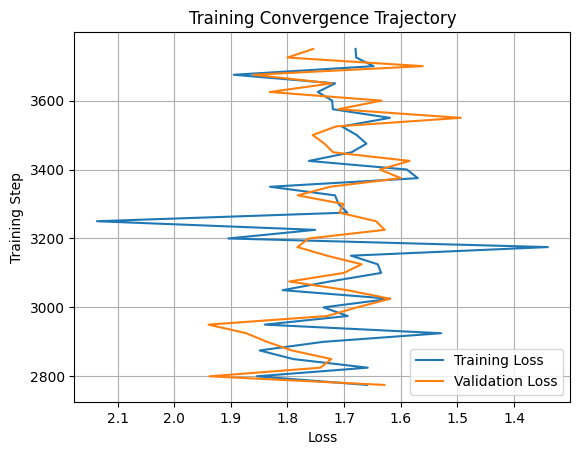

In [12]:
print(loss.item())

# Loss on X-axis, step on Y-axis
plt.plot(train_losses, train_steps, label="Training Loss")
plt.plot(val_losses, train_steps, label="Validation Loss")

plt.xlabel("Loss")
plt.ylabel("Training Step")
plt.title("Training Convergence Trajectory")

plt.gca().invert_xaxis()  
# plt.gca().invert_yaxis()  

plt.legend()
plt.grid(True)
plt.show()

In [13]:
with open('model-01.pkl', 'wb') as f:
    pickle.dump(model, f)
print('model saved')

model saved


In [14]:
# prompt = 'Hello! Can you see me?'
# context = torch.tensor(encode(prompt), dtype=torch.long, device=device)
# model.eval()  # important: disable dropout

# generated_chars = decode(
#     model.generate(context.unsqueeze(0), max_new_tokens=100)[0].tolist()
# )

# model.train()  # optional: switch back if training continues

# print(generated_chars)


In [15]:
def chat_with_model(model):

    model.eval()

    while True:
        prompt = input(">> You: ")
        if prompt.lower() in {"exit", "quit"}:
            break

        context = torch.tensor(encode(prompt), dtype=torch.long, device=device)
        context = context.unsqueeze(0)  # (1, T)

        with torch.no_grad():
            generated = model.generate(context, max_new_tokens=100)

        response = decode(generated[0].tolist())
        print(">> Model:", response)

chat_with_model(model)

>> You:  hello


>> Model: hellower to such is not communizater try leless to live gart we cootists is parts busing constic from as 


>> You:  lala


>> Model: lalary the lessly, cashing to a pery abe out this bader, and an himrilous the reaching four counning by 


>> You:  hello 


>> Model: hello this Erca spared being I campaschicative out Stanher Garora Well Fin’t Since you Gring.”

If usience


>> You:  hello 


>> Model: hello have previtial fany he goddn’ts not to bord is issurized of this resists to reated on a opener’s hn 


>> You:  exit
